## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Get dataset

Classifying Laptops and PCs we load images of latops and images of pcs (we initially downloaded from google images) that initially were seperated into training and test data.\
The test data consists of about 25% of the whole data set.

In [2]:
data_dir = pathlib.Path("./LaptopVsPc/training")
test_dir = pathlib.Path("./LaptopVsPc/test")

## Analyse data

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

270


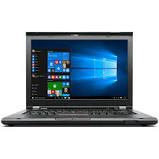

In [4]:
laptops = list(data_dir.glob('laptop/*'))
PIL.Image.open(str(laptops[5]))

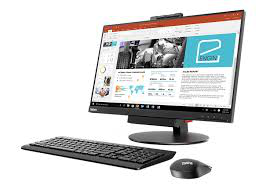

In [5]:
pc = list(data_dir.glob('pc/*'))
PIL.Image.open(str(pc[5]))

## Create dataset

Later, we are also using an image generator to generate more image data to train the model with => to achieve a better result (even tough it was even worse).

In [6]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False
)

IMG_HEIGHT, IMG_WIDTH = 180, 180
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=data_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

test_data_gen = train_image_generator.flow_from_directory(directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

print(train_data_gen.class_indices)   


Found 270 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 270 files belonging to 2 classes.
Using 216 files for training.
Found 270 files belonging to 2 classes.
Using 54 files for validation.
Found 110 files belonging to 2 classes.
{'laptop': 0, 'pc': 1}


## Look at generated samples

The generated images look like real use-cases and are therefore highly suitable for training the model.

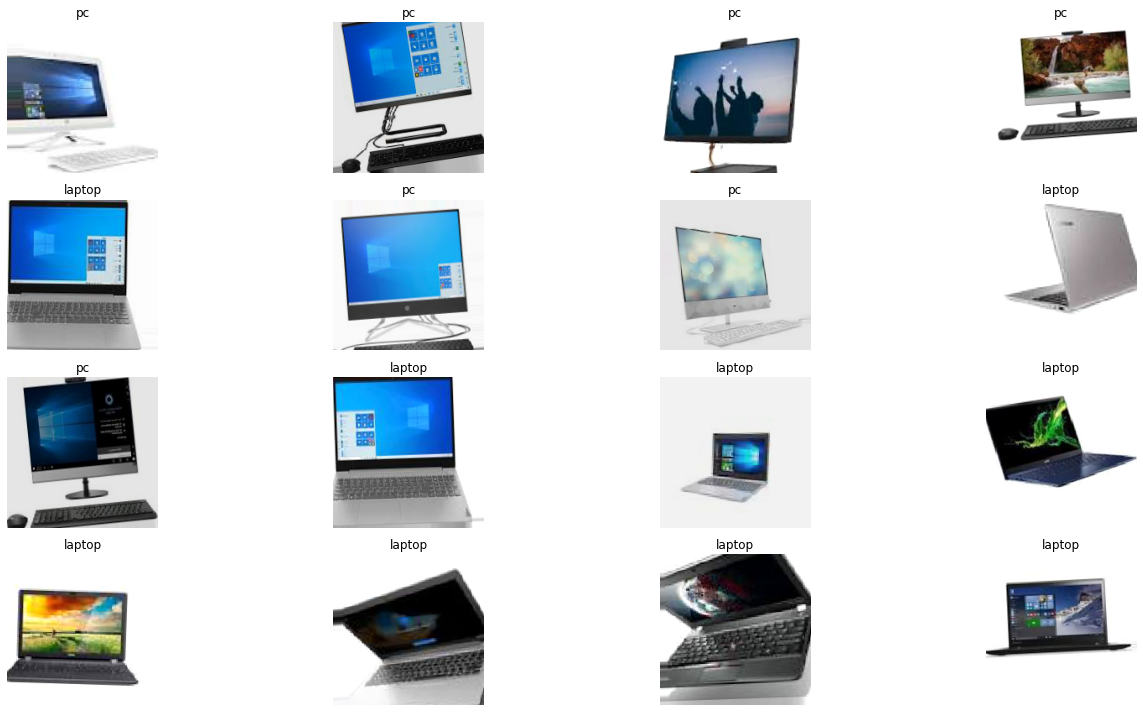

In [7]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(4, 4, figsize=(20,10))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

## Create model

We are creating 3 models, each with a different amount of layers to test how many layers are optimal.\
The model with 8 layers (model2) always performed best.

### Model with 10 layers

In [8]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Model with 8 layers

In [9]:
model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Model with 6 layers

In [10]:
model3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile models

In [11]:
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

model2.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

model3.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [12]:
print('\nModel with 10 Layers:\n')
model.summary()
print('\nModel with 8 Layers:\n')
model2.summary()
print('\nModel with 6 Layers:\n')
model3.summary()


Model with 10 Layers:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (No

## Training models

In [13]:
epochs = 5

history = model.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
7/7 [==============================] - 3s 453ms/step - loss: 0.7954 - accuracy: 0.6389 - val_loss: 0.4788 - val_accuracy: 0.8519
Epoch 2/5
7/7 [==============================] - 3s 438ms/step - loss: 0.4008 - accuracy: 0.8380 - val_loss: 0.3053 - val_accuracy: 0.8889
Epoch 3/5
7/7 [==============================] - 3s 443ms/step - loss: 0.2424 - accuracy: 0.9259 - val_loss: 0.1719 - val_accuracy: 0.9630
Epoch 4/5
7/7 [==============================] - 3s 418ms/step - loss: 0.1335 - accuracy: 0.9537 - val_loss: 0.1197 - val_accuracy: 0.9630
Epoch 5/5
7/7 [==============================] - 3s 454ms/step - loss: 0.0886 - accuracy: 0.9722 - val_loss: 0.1369 - val_accuracy: 0.9444


In [14]:
def plot_train_val_loss_and_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

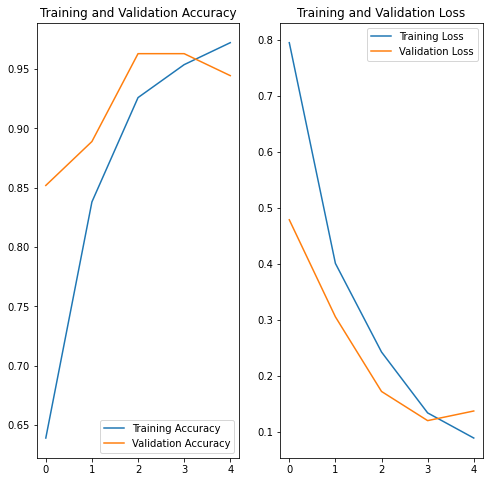

In [15]:
plot_train_val_loss_and_acc(history)

In [16]:
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
7/7 [==============================] - 5s 768ms/step - loss: 4.2574 - accuracy: 0.5787 - val_loss: 2.2110 - val_accuracy: 0.6296
Epoch 2/5
7/7 [==============================] - 6s 854ms/step - loss: 1.2882 - accuracy: 0.5833 - val_loss: 0.6773 - val_accuracy: 0.4074
Epoch 3/5
7/7 [==============================] - 6s 924ms/step - loss: 0.4828 - accuracy: 0.7639 - val_loss: 0.4229 - val_accuracy: 0.7778
Epoch 4/5
7/7 [==============================] - 5s 742ms/step - loss: 0.2540 - accuracy: 0.9259 - val_loss: 0.3257 - val_accuracy: 0.8333
Epoch 5/5
7/7 [==============================] - 6s 791ms/step - loss: 0.1169 - accuracy: 0.9583 - val_loss: 0.2135 - val_accuracy: 0.9074


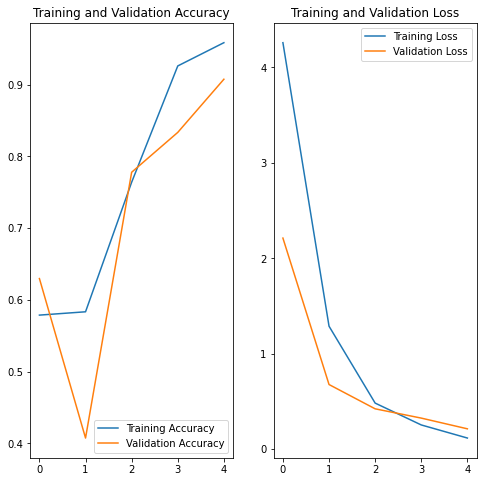

In [17]:
plot_train_val_loss_and_acc(history2)

In [18]:
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
7/7 [==============================] - 7s 1s/step - loss: 42.0473 - accuracy: 0.5093 - val_loss: 21.8049 - val_accuracy: 0.3704
Epoch 2/5
7/7 [==============================] - 8s 1s/step - loss: 8.4465 - accuracy: 0.4861 - val_loss: 3.9053 - val_accuracy: 0.6296
Epoch 3/5
7/7 [==============================] - 8s 1s/step - loss: 3.0394 - accuracy: 0.5278 - val_loss: 0.6636 - val_accuracy: 0.6296
Epoch 4/5
7/7 [==============================] - 8s 1s/step - loss: 0.6540 - accuracy: 0.7130 - val_loss: 0.6501 - val_accuracy: 0.4630
Epoch 5/5
7/7 [==============================] - 7s 967ms/step - loss: 0.5969 - accuracy: 0.6713 - val_loss: 0.5675 - val_accuracy: 0.9259


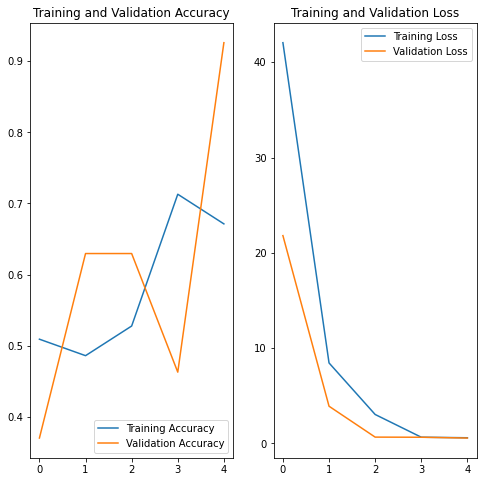

In [19]:
plot_train_val_loss_and_acc(history3)

## Metrics

Now we look at the resulting loss, the resulting accuracy, true and false positives/negatives and the AUC of the 3 models.

In [20]:
def print_metrics(test_ds, model):
    score = model.evaluate(test_ds)
    evaluate_metrics = dict(zip(model.metrics_names, score))
    print('\n', evaluate_metrics)
    
    predictions = model.predict(test_ds, verbose=0)
    labels = np.array([x[1].numpy() for x in list(test_ds)])

    def take_label(x):
        if x[0] > x[1]:
            return 0
        else:
            return 1

    predictions = np.array([take_label(xi) for xi in predictions])
    labels = np.concatenate(labels).ravel()

    tn = tf.keras.metrics.TrueNegatives()
    tn.update_state(predictions, labels)
    print("True Negatives: ", tn.result().numpy())
    tp = tf.keras.metrics.TruePositives()
    tp.update_state(predictions, labels)
    print("True Positives: ", tp.result().numpy())
    fn = tf.keras.metrics.FalseNegatives()
    fn.update_state(predictions, labels)
    print("False Negatives: ", fn.result().numpy())
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(predictions, labels)
    print("False Positives: ", fp.result().numpy())
    auc = tf.keras.metrics.AUC()
    auc.update_state(predictions, labels)
    print("AUC: ", auc.result().numpy())

In [21]:
print_metrics(test_ds, model)

4/4 [==============================] - 0s 92ms/step - loss: 0.3476 - accuracy: 0.8727

 {'loss': 0.3475894629955292, 'accuracy': 0.8727272748947144}
True Negatives:  25.0
True Positives:  25.0
False Negatives:  35.0
False Positives:  25.0
AUC:  0.4583333


In [22]:
print_metrics(test_ds, model2)

4/4 [==============================] - 1s 143ms/step - loss: 0.3669 - accuracy: 0.8818

 {'loss': 0.3668879568576813, 'accuracy': 0.8818181753158569}
True Negatives:  41.0
True Positives:  28.0
False Negatives:  19.0
False Positives:  22.0
AUC:  0.6232692


The model with 8 layers always performed best!

In [23]:
print_metrics(test_ds, model3)

4/4 [==============================] - 1s 154ms/step - loss: 0.5849 - accuracy: 0.8091

 {'loss': 0.5849024057388306, 'accuracy': 0.8090909123420715}
True Negatives:  37.0
True Positives:  20.0
False Negatives:  23.0
False Positives:  30.0
AUC:  0.50867754


From the current run the model with 6 layers performs second-best and the model with 10 layers performs worst.\
But in different runs the results were fliped and the model with 10 layers performed better.\
Therfore we cannot really say which layer-configuration is better suited for this problem.

## Model with generated images

Now we are trying to use the image generator to increase the accuracy, but acctually it never even reached 0.5!

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              # metrics cannot calculate roc curve "metrics=[tf.keras.metrics.AUC()]", 
              # since the model would then get an InvalidArgument error
              metrics=['accuracy'])
               
history4 = model.fit(train_data_gen,
          steps_per_epoch=image_count / batch_size, epochs=epochs)        

Epoch 1/5
9/8 [================================] - 5s 543ms/step - loss: 8.8351 - accuracy: 0.4519
Epoch 2/5
9/8 [================================] - 5s 504ms/step - loss: 8.8351 - accuracy: 0.4519
Epoch 3/5
9/8 [================================] - 5s 504ms/step - loss: 8.8351 - accuracy: 0.4519
Epoch 4/5
9/8 [================================] - 5s 510ms/step - loss: 8.8351 - accuracy: 0.4519
Epoch 5/5
9/8 [================================] - 5s 517ms/step - loss: 8.8351 - accuracy: 0.4519


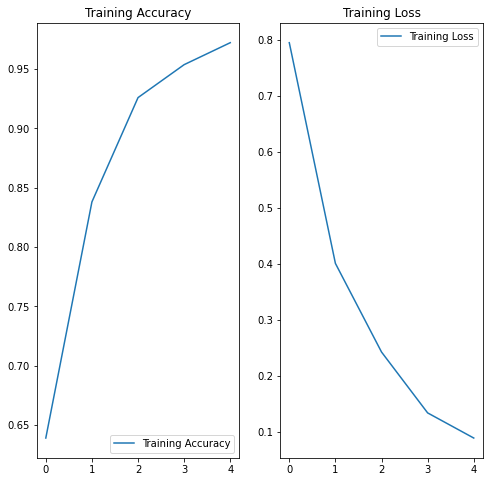

In [25]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [27]:
score = model.evaluate(test_data_gen)
evaluate_metrics = dict(zip(model.metrics_names, score))
print('\n', evaluate_metrics)

4/4 [==============================] - 1s 196ms/step - loss: 8.7917 - accuracy: 0.4545

 {'loss': 8.791688919067383, 'accuracy': 0.4545454680919647}


## Model with different optimizer and loss function

We also try what result we get with different combinations of different optimizers and different loss functions.

### SGD and MSE

Epoch 1/5
7/7 [==============================] - 3s 381ms/step - loss: 0.2290 - accuracy: 0.8009 - val_loss: 0.2119 - val_accuracy: 0.8333
Epoch 2/5
7/7 [==============================] - 3s 393ms/step - loss: 0.2206 - accuracy: 0.8056 - val_loss: 0.2391 - val_accuracy: 0.8333
Epoch 3/5
7/7 [==============================] - 3s 404ms/step - loss: 0.2148 - accuracy: 0.7917 - val_loss: 0.2149 - val_accuracy: 0.8148
Epoch 4/5
7/7 [==============================] - 3s 374ms/step - loss: 0.2108 - accuracy: 0.7963 - val_loss: 0.2234 - val_accuracy: 0.8704
Epoch 5/5
7/7 [==============================] - 3s 365ms/step - loss: 0.2054 - accuracy: 0.8148 - val_loss: 0.1988 - val_accuracy: 0.8333


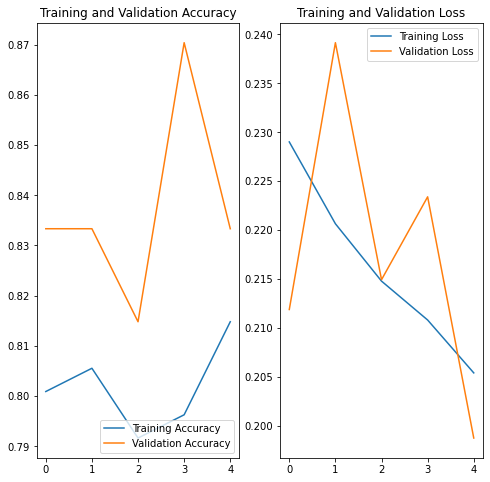

4/4 [==============================] - 0s 65ms/step - loss: 0.1870 - accuracy: 0.8636

 {'loss': 0.18702112138271332, 'accuracy': 0.8636363744735718}
True Negatives:  33.0
True Positives:  26.0
False Negatives:  27.0
False Positives:  24.0
AUC:  0.5347567


In [31]:
model.compile(optimizer='sgd', loss='mse',
          metrics=['accuracy'])

history5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

plot_train_val_loss_and_acc(history5)

print_metrics(test_ds, model)

### Adam and MSE

Epoch 1/5
7/7 [==============================] - 3s 387ms/step - loss: 0.2818 - accuracy: 0.6250 - val_loss: 0.1965 - val_accuracy: 0.6296
Epoch 2/5
7/7 [==============================] - 3s 409ms/step - loss: 0.1787 - accuracy: 0.6204 - val_loss: 0.1440 - val_accuracy: 0.4444
Epoch 3/5
7/7 [==============================] - 3s 479ms/step - loss: 0.1141 - accuracy: 0.8102 - val_loss: 0.0889 - val_accuracy: 0.8889
Epoch 4/5
7/7 [==============================] - 3s 490ms/step - loss: 0.0896 - accuracy: 0.9213 - val_loss: 0.1012 - val_accuracy: 0.6667
Epoch 5/5
7/7 [==============================] - 3s 481ms/step - loss: 0.0790 - accuracy: 0.8472 - val_loss: 0.0878 - val_accuracy: 0.9074


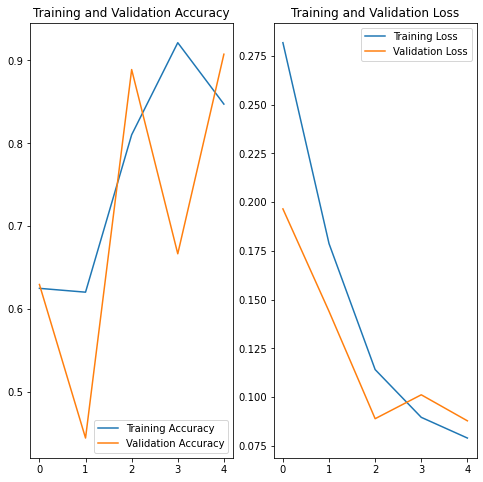

4/4 [==============================] - 0s 78ms/step - loss: 0.1376 - accuracy: 0.8818

 {'loss': 0.13758443295955658, 'accuracy': 0.8818181753158569}
True Negatives:  31.0
True Positives:  24.0
False Negatives:  29.0
False Positives:  26.0
AUC:  0.49834493


In [32]:
model.compile(optimizer='adam', loss='mse',
          metrics=['accuracy'])

history5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

plot_train_val_loss_and_acc(history5)

print_metrics(test_ds, model)

### SGD and CategoricalHinge

Epoch 1/5
7/7 [==============================] - 3s 394ms/step - loss: 0.5159 - accuracy: 0.8472 - val_loss: 0.3306 - val_accuracy: 0.7407
Epoch 2/5
7/7 [==============================] - 3s 372ms/step - loss: 0.2936 - accuracy: 0.8380 - val_loss: 0.3107 - val_accuracy: 0.8519
Epoch 3/5
7/7 [==============================] - 3s 370ms/step - loss: 0.3366 - accuracy: 0.8380 - val_loss: 1.2280 - val_accuracy: 0.8519
Epoch 4/5
7/7 [==============================] - 3s 371ms/step - loss: 0.3931 - accuracy: 0.8241 - val_loss: 0.2395 - val_accuracy: 0.8704
Epoch 5/5
7/7 [==============================] - 3s 401ms/step - loss: 0.2684 - accuracy: 0.8750 - val_loss: 0.2384 - val_accuracy: 0.9074


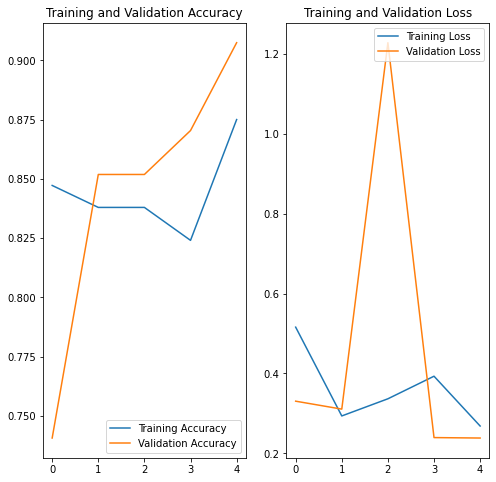

4/4 [==============================] - 0s 74ms/step - loss: 0.3111 - accuracy: 0.8818

 {'loss': 0.3111439347267151, 'accuracy': 0.8818181753158569}
True Negatives:  35.0
True Positives:  28.0
False Negatives:  25.0
False Positives:  22.0
AUC:  0.57116854


In [33]:
model.compile(optimizer='sgd', loss='categorical_hinge',
          metrics=['accuracy'])

history5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

plot_train_val_loss_and_acc(history5)

print_metrics(test_ds, model)

### Adadelta and SparseCategoricalCrossentropy

Epoch 1/5
7/7 [==============================] - 3s 464ms/step - loss: 0.5721 - accuracy: 0.9306 - val_loss: 0.5762 - val_accuracy: 0.9259
Epoch 2/5
7/7 [==============================] - 3s 462ms/step - loss: 0.5717 - accuracy: 0.9306 - val_loss: 0.5756 - val_accuracy: 0.9259
Epoch 3/5
7/7 [==============================] - 4s 505ms/step - loss: 0.5712 - accuracy: 0.9352 - val_loss: 0.5751 - val_accuracy: 0.9259
Epoch 4/5
7/7 [==============================] - 3s 496ms/step - loss: 0.5707 - accuracy: 0.9352 - val_loss: 0.5745 - val_accuracy: 0.9259
Epoch 5/5
7/7 [==============================] - 3s 454ms/step - loss: 0.5703 - accuracy: 0.9352 - val_loss: 0.5740 - val_accuracy: 0.9259


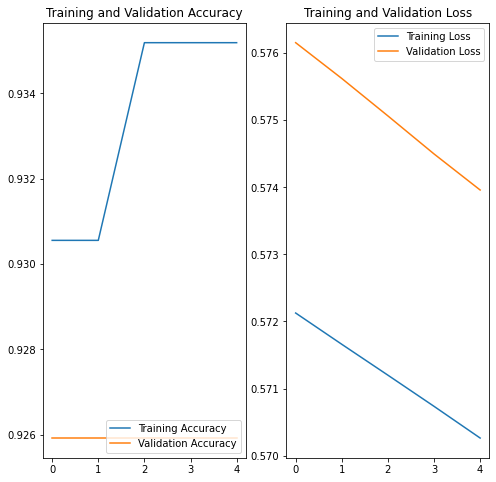

4/4 [==============================] - 0s 86ms/step - loss: 0.5710 - accuracy: 0.8818

 {'loss': 0.5709546804428101, 'accuracy': 0.8818181753158569}
True Negatives:  32.0
True Positives:  25.0
False Negatives:  28.0
False Positives:  25.0
AUC:  0.5165508


In [35]:
model.compile(optimizer='adadelta', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

history5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

plot_train_val_loss_and_acc(history5)

print_metrics(test_ds, model)

We observe that there is not really a best model, since 4 of the 3 models performed equally well in accuracy.\
But there is a worst model for accuracy, as the first model of this section performed not as good as the remaining three models.

But taking the AUC into account, the best model was the 'SGD and CategoricalHinge' model with an AUC of 0.57!\
(It is not better than our initial model2 having 8 layers tough (AUC: 0.62).)